In [1]:
%matplotlib inline

import gym
import GPy
import GPyOpt
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

import gympy

In [2]:
env, observations, inputsNumpy, observationsNumpy, rewardsNumpy, action, predictionPDF = gympy.setupEnvironment(defaultEnvironment = 'Pendulum-v0', whichVersion = 0)
k_dynamics = GPy.kern.RBF(input_dim=4, variance=1., lengthscale=1.)
k_rewards = GPy.kern.RBF(input_dim=3, variance=1., lengthscale=1.)

def action_fromPolicy(policyParameters, bufferObservations_policy):
    actionToTake_policy = 0
    [r,c] = policyParameters.shape
    for i in range(c):
        if i < c-1:
            actionToTake_policy = actionToTake_policy + (bufferObservations_policy[0,i] * policyParameters[0,i])
        else:
            actionToTake_policy = actionToTake_policy + policyParameters[0,i]
    actionToTake_policy = 2 * ((9/8)*np.sin(actionToTake_policy) + (1/8)*np.sin(3*actionToTake_policy))         

    return actionToTake_policy



Please enter the environment: 


[2016-11-24 19:31:27,762] Making new env: Pendulum-v0


In [3]:
totalIterations = 100
counter = 1
policyParameters = np.array([[-0.49200146,  0.23965896,  1,         -8.94638503]])

for attempt in range(500):
    if attempt%100 == 0:
        observations = env.reset(whichVersion=1)
    
    bufferObservations = np.reshape(observations, ([1,3]))
    actionToTake = action_fromPolicy(policyParameters, bufferObservations)
    actionToTake_random = env.action_space.sample()
    
    inputsNumpy, bufferInput = gympy.appendInputArray(inputsNumpy, actionToTake_random, observations, attempt)
    
    actionToTake = np.array([actionToTake])
    
    [observationsNumpy, bufferObservations] = gympy.appendObservationsArray(observationsNumpy, observations, attempt)
    
    observations, rewards, done, info = env.step(actionToTake)
    
m_dynamics = gympy.generateModel(inputsNumpy, observationsNumpy, k_dynamics)
m_dynamics.optimize()

[2016-11-24 19:31:28,079] initializing Y
[2016-11-24 19:31:28,080] initializing inference method
[2016-11-24 19:31:28,080] adding kernel and likelihood as parameters


In [5]:
useBelief = False
avgErrorSummary = np.zeros([1])
modelCounter = 0

for i in range(400):
    observations_sim = env.reset(whichVersion=1)
    observations = np.reshape(observations_sim, ([1,3]))
    predictionPDF = observations
    actionToTake_policy = action_fromPolicy(policyParameters, observations)
    counter = 1
    print inputsNumpy.shape, avgErrorSummary.shape, observations_sim
    while abs(observations[0,0]) > np.cos(5*np.pi/180) and counter <= totalIterations:
            
            bufferActionToTake = np.array([actionToTake_policy])
            bufferActionToTake = np.reshape(bufferActionToTake, ([1]))
            bufferActionToTake_toAppend = np.reshape(bufferActionToTake,([1,1]))
            bufferInputs_policy = np.append(bufferActionToTake_toAppend, observations, axis = 1) 

            [observationsNumpy, bufferObservations] = gympy.appendObservationsArray(observationsNumpy, observations_sim, counter)
            [inputsNumpy, bufferInput] = gympy.appendInputArray(inputsNumpy, bufferActionToTake, observations_sim, counter)


            observations_sim, rewards, done, info = env.step(bufferActionToTake)
            predictionPDF = m_dynamics.predict(bufferInputs_policy)[0]

            observations = np.reshape(observations_sim, ([1,3]))
            predictionPDF = np.reshape(predictionPDF, ([1,3]))

            if counter == 1:
                observationsSummary = observations
                predictionSummary = predictionPDF
                errorSummary = abs((predictionPDF - observations)/observations)
            else:
                observationsSummary = np.append(observationsSummary, observations, axis = 0)
                predictionSummary = np.append(predictionSummary, predictionPDF, axis = 0)
                errorSummary = np.append(errorSummary, abs((predictionPDF - observations)/observations), axis = 0)

            actionToTake_policy = action_fromPolicy(policyParameters,observations)

            counter += 1

    avgError = np.mean(errorSummary) * 100
    avgErrorSummary = np.append(avgErrorSummary, np.reshape(avgError, ([1])), axis = 0)

    if inputsNumpy.shape[0] - modelCounter >= 1000:
        print 'training GP model'
        m_dynamics = gympy.generateModel(inputsNumpy, observationsNumpy, k_dynamics)
        m_dynamics.optimize() 
        modelCounter = inputsNumpy.shape[0]

[2016-11-24 19:35:28,131] initializing Y
[2016-11-24 19:35:28,132] initializing inference method
[2016-11-24 19:35:28,132] adding kernel and likelihood as parameters


(1051, 4) (1,) [  9.99999895e-01  -4.59233585e-04   0.00000000e+00]
training GP model
(1084, 4) (2,) [ 0.99996332  0.00856449  0.        ]
(1107, 4) (3,) [ 0.99998955 -0.00457138  0.        ]
(1155, 4) (4,) [ 0.99999646 -0.00265968  0.        ]
(1194, 4) (5,) [  9.99999705e-01  -7.68478497e-04   0.00000000e+00]
(1228, 4) (6,) [ 0.99999801  0.00199515  0.        ]
(1257, 4) (7,) [ 0.99999573  0.00292164  0.        ]
(1285, 4) (8,) [  9.99999951e-01  -3.13228993e-04   0.00000000e+00]
(1318, 4) (9,) [ 0.99999786  0.00206975  0.        ]
(1347, 4) (10,) [ 0.99998963 -0.0045547   0.        ]
(1395, 4) (11,) [ 0.99997764  0.00668721  0.        ]
(1419, 4) (12,) [ 0.99997745 -0.00671575  0.        ]
(1474, 4) (13,) [ 0.99996961  0.00779614  0.        ]
(1497, 4) (14,) [ 0.99999686  0.0025059   0.        ]
(1526, 4) (15,) [ 0.99997372 -0.00724946  0.        ]
(1575, 4) (16,) [ 0.99997042  0.00769143  0.        ]
(1598, 4) (17,) [ 0.99996851 -0.0079363   0.        ]
(1642, 4) (18,) [ 0.99997855

[2016-11-24 19:35:36,323] initializing Y
[2016-11-24 19:35:36,324] initializing inference method
[2016-11-24 19:35:36,325] adding kernel and likelihood as parameters


(1991, 4) (28,) [ 0.99998713  0.00507325  0.        ]
(2017, 4) (29,) [ 0.99998859  0.00477736  0.        ]
(2043, 4) (30,) [ 0.99997528  0.00703095  0.        ]
(2067, 4) (31,) [ 0.99997207  0.00747452  0.        ]
training GP model
(2091, 4) (32,) [ 0.99999589 -0.00286664  0.        ]
(2131, 4) (33,) [ 0.99997715 -0.00675988  0.        ]
(2185, 4) (34,) [ 0.99999815  0.00192476  0.        ]
(2215, 4) (35,) [ 0.99999208 -0.00397931  0.        ]
(2260, 4) (36,) [ 0.99998523  0.00543545  0.        ]
(2285, 4) (37,) [ 0.99997479 -0.00710113  0.        ]
(2335, 4) (38,) [  9.99999913e-01  -4.16134843e-04   0.00000000e+00]
(2368, 4) (39,) [ 0.99997337  0.00729853  0.        ]
(2392, 4) (40,) [ 0.99999921 -0.00126033  0.        ]
(2427, 4) (41,) [ 0.99997338 -0.0072967   0.        ]
(2475, 4) (42,) [ 0.99999346  0.003618    0.        ]
(2502, 4) (43,) [ 0.99999836 -0.00181206  0.        ]
(2539, 4) (44,) [ 0.99999781  0.0020941   0.        ]
(2568, 4) (45,) [ 0.9999991  -0.00134045  0.     

[2016-11-24 19:35:49,556] initializing Y
[2016-11-24 19:35:49,556] initializing inference method
[2016-11-24 19:35:49,557] adding kernel and likelihood as parameters


training GP model
(3094, 4) (61,) [ 0.99998336 -0.00576843  0.        ]
(3162, 4) (62,) [ 0.99997628  0.00688817  0.        ]
(3186, 4) (63,) [  9.99999611e-01  -8.82093502e-04   0.00000000e+00]
(3220, 4) (64,) [ 0.99997347 -0.0072844   0.        ]
(3268, 4) (65,) [ 0.99999529  0.00306872  0.        ]
(3296, 4) (66,) [ 0.99998782 -0.00493646  0.        ]
(3348, 4) (67,) [ 0.99998205  0.00599082  0.        ]
(3373, 4) (68,) [ 0.99998833  0.00483105  0.        ]
(3399, 4) (69,) [ 0.9999773  -0.00673734  0.        ]
(3453, 4) (70,) [ 0.99999734  0.00230537  0.        ]
(3482, 4) (71,) [  9.99999871e-01  -5.06975146e-04   0.00000000e+00]
(3516, 4) (72,) [ 0.99998508 -0.0054617   0.        ]
(3575, 4) (73,) [ 0.9999897   0.00453945  0.        ]
(3601, 4) (74,) [ 0.99998548 -0.00538948  0.        ]
(3659, 4) (75,) [ 0.99999375 -0.00353635  0.        ]
(3701, 4) (76,) [ 0.99998866  0.00476174  0.        ]
(3727, 4) (77,) [ 0.99996477 -0.00839453  0.        ]
(3768, 4) (78,) [ 0.99999921 -0.00

[2016-11-24 19:38:18,595] initializing Y
[2016-11-24 19:38:18,596] initializing inference method
[2016-11-24 19:38:18,597] adding kernel and likelihood as parameters


training GP model
(4114, 4) (87,) [ 0.99996305 -0.00859619  0.        ]
(4154, 4) (88,) [ 0.99997858  0.00654505  0.        ]
(4178, 4) (89,) [ 0.99999679  0.0025332   0.        ]
(4207, 4) (90,) [ 0.99997928  0.00643734  0.        ]
(4232, 4) (91,) [ 0.99999562  0.00295931  0.        ]
(4260, 4) (92,) [ 0.99999784  0.00208074  0.        ]
(4289, 4) (93,) [  9.99999795e-01  -6.40872641e-04   0.00000000e+00]
(4323, 4) (94,) [ 0.99999695  0.00247111  0.        ]
(4352, 4) (95,) [ 0.99997409  0.00719849  0.        ]
(4376, 4) (96,) [ 0.99997408  0.00719983  0.        ]
(4400, 4) (97,) [  9.99999911e-01   4.20746641e-04   0.00000000e+00]
(4432, 4) (98,) [ 0.99997209 -0.00747131  0.        ]
(4479, 4) (99,) [ 0.99999115 -0.0042069   0.        ]
(4525, 4) (100,) [ 0.99999883  0.00153156  0.        ]
(4555, 4) (101,) [ 0.99999571  0.00292972  0.        ]
(4583, 4) (102,) [ 0.99999743 -0.00226525  0.        ]
(4621, 4) (103,) [ 0.99999945  0.00105196  0.        ]
(4652, 4) (104,) [ 0.99998143 

[2016-11-24 19:40:10,231] initializing Y
[2016-11-24 19:40:10,233] initializing inference method
[2016-11-24 19:40:10,233] adding kernel and likelihood as parameters


training GP model
(5127, 4) (116,) [ 0.99999934  0.00114679  0.        ]
(5158, 4) (117,) [ 0.99997781  0.00666128  0.        ]
(5182, 4) (118,) [ 0.99997964 -0.00638168  0.        ]
(5244, 4) (119,) [ 0.99998385 -0.0056833   0.        ]
(5309, 4) (120,) [ 0.99999478 -0.00323095  0.        ]
(5350, 4) (121,) [ 0.99999821 -0.0018901   0.        ]
(5387, 4) (122,) [ 0.99999512  0.00312531  0.        ]
(5415, 4) (123,) [ 0.99997821 -0.00660146  0.        ]
(5472, 4) (124,) [ 0.99996658  0.00817603  0.        ]
(5495, 4) (125,) [ 0.99999759  0.00219382  0.        ]
(5524, 4) (126,) [ 0.99998918  0.00465091  0.        ]
(5550, 4) (127,) [  9.99999889e-01   4.71895656e-04   0.00000000e+00]
(5582, 4) (128,) [ 0.99997598 -0.00693145  0.        ]
(5634, 4) (129,) [ 0.99999845 -0.00176351  0.        ]
(5670, 4) (130,) [ 0.99999474  0.00324311  0.        ]
(5698, 4) (131,) [ 0.99998226 -0.00595716  0.        ]
(5782, 4) (132,) [ 0.99998327 -0.0057844   0.        ]
(5851, 4) (133,) [ 0.99999704  0

[2016-11-24 19:42:43,683] initializing Y
[2016-11-24 19:42:43,683] initializing inference method
[2016-11-24 19:42:43,684] adding kernel and likelihood as parameters


training GP model
(6166, 4) (143,) [ 0.99999868  0.00162258  0.        ]
(6196, 4) (144,) [ 0.99998847  0.00480131  0.        ]
(6222, 4) (145,) [ 0.99999914 -0.00131055  0.        ]
(6257, 4) (146,) [ 0.99999938 -0.00111528  0.        ]
(6292, 4) (147,) [ 0.99999178 -0.00405401  0.        ]
(6337, 4) (148,) [ 0.9999949   0.00319265  0.        ]
(6365, 4) (149,) [ 0.99996666  0.00816573  0.        ]
(6388, 4) (150,) [ 0.99999403  0.00345419  0.        ]
(6416, 4) (151,) [ 0.99999142  0.00414337  0.        ]
(6443, 4) (152,) [ 0.99999725 -0.00234497  0.        ]
(6481, 4) (153,) [ 0.99998639  0.00521801  0.        ]
(6507, 4) (154,) [ 0.99999515 -0.00311467  0.        ]
(6548, 4) (155,) [ 0.99999723 -0.0023552   0.        ]
(6586, 4) (156,) [ 0.99996688  0.0081385   0.        ]
(6609, 4) (157,) [ 0.99996745  0.00806833  0.        ]
(6632, 4) (158,) [ 0.99999604 -0.00281306  0.        ]
(6672, 4) (159,) [ 0.99998113 -0.00614278  0.        ]
(6746, 4) (160,) [ 0.99998272  0.00587803  0.  

[2016-11-24 19:49:06,109] initializing Y
[2016-11-24 19:49:06,110] initializing inference method
[2016-11-24 19:49:06,111] adding kernel and likelihood as parameters


training GP model
KeyboardInterrupt caught, calling on_optimization_end() to round things up


KeyboardInterrupt: 

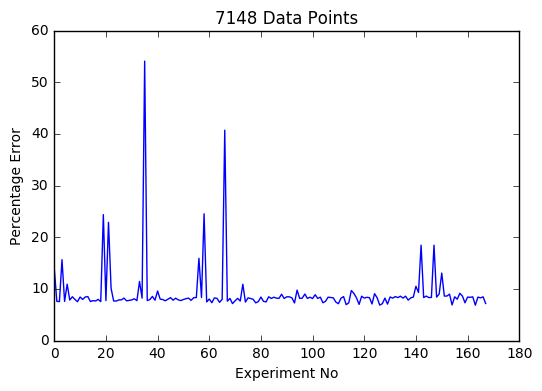

In [12]:
plt.plot(avgErrorSummary[5::])
plt.title('7148 Data Points')
plt.xlabel('Experiment No')
plt.ylabel('Percentage Error')
plt.savefig('7148_datapoints', format = 'svg')